# 1. 메모리 변수 제거

In [1]:
# 메모리 변수 모두 제거
all = [var for var in globals() if var[0] != '_']
for var in all:
    del globals()[var]

# 2. 사용 패키지

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
!apt-get install -y fonts-nanum > /dev/null
!fc-cache -fv > /dev/null
!rm -rf ~/.cache/matplotlib > /dev/null
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family = 'NanumBarunGothic')
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import math
from PIL import Image

# 3. 데이터 로드

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd /content/drive/MyDrive/data/project02

/content/drive/MyDrive/data/project02


In [6]:
train_npz = np.load('npz/train_cucumber.npz')
test_npz = np.load('npz/val_cucumber.npz')
print(list(train_npz))
print(list(test_npz))

['X', 'Y']
['X', 'Y']


In [7]:
X_train = train_npz['X']
y_train = train_npz['Y']
X_val = test_npz['X']
y_val = test_npz['Y']
print(np.shape(X_train), len(y_train))
print(np.shape(X_val), len(y_val))

(1958, 255, 255, 3) 1958
(1147, 255, 255, 3) 1147


In [8]:
unique, counts = np.unique(y_train, return_counts = True)
unique_yt = dict(zip(unique, counts))
unique_yt

{0.0: 1000, 1.0: 500, 2.0: 458}

In [9]:
unique, counts = np.unique(y_val, return_counts = True)
unique_yv = dict(zip(unique, counts))
unique_yv

{0.0: 1000, 1.0: 110, 2.0: 37}

# 4. Keras ResNet50
- tf.keras.applications.resnet50.ResNet50(include_top = True, weights = 'imagenet', input_tensor = None, input_shape = None, pooling = None, classes = 1000, **kwargs
)
- keras.applications.resnet.ResNet50(include_top = True, weights = 'imagenet', input_tensor = None, input_shape = None, pooling = None, classes = 1000)
    - include_top: 네트워크의 최상단에 완전 연결 레이어를 넣을지 여부.
    - weights: None (임의의 초기값 설정) 혹은 'imagenet' (ImageNet에 대한 선행 학습) 중 하나.
    - input_tensor: 모델의 이미지 인풋으로 사용할 수 있는 선택적 케라스 텐서 (다시말해, layers.Input()의 아웃풋).
    - input_shape: 선택적 형태 튜플로, include_top이 False일 경우만 특정하십시오. (그렇지 않다면 인풋의 형태가 (224, 224, 3)이고 'channels_last' 데이터 포맷을 취하거나 혹은 인풋의 형태가 (3, 224, 224)이고 'channels_first' 데이터 포맷을 취해야 합니다). 인풋 채널이 정확히 3개여야 하며 넓이와 높이가 32 미만이어서는 안됩니다. 예시. (200, 200, 3)은 유효한 값입니다.
    - pooling: 특성추출을 위한 선택적 풀링 모드로, include_top이 False일 경우 유효합니다.
None은 모델의 아웃풋이 마지막 컨볼루션 레이어의 4D 텐서 아웃풋임을 의미합니다.
'avg'는 글로벌 평균값 풀링이 마지막 컨볼루션 레이어의 아웃풋에 적용되어 모델의 아웃풋이 2D 텐서가 됨을 의미합니다.
'max'는 글로벌 최대값 풀링이 적용됨을 의미합니다.
    - classes: 이미지를 분류하기 위한 선택적 클래스의 수로, include_top이 True일 경우, 그리고 weights 인수가 따로 정해지지 않은 경우만 특정합니다.

In [10]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, Input, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator


input = Input(shape=(255,255,3))
model = tf.keras.applications.resnet50.ResNet50(
    include_top = False,
    weights = None,
    input_tensor = input,
    pooling = 'max'
)

In [11]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 255, 255, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 261, 261, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [12]:
es = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1,
    patience = 10
)
save = tf.keras.callbacks.ModelCheckpoint(
    'npz/best_model.h5',
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True
)
callback = [es, save]

In [13]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

In [14]:
history = model.fit(
    X_train, y_train,
    epochs = 80,
    batch_size = 64,
    validation_data = (X_val, y_val),
    callbacks = callback
)

Epoch 1/80
62/62 [==============================] - 223s 4s/step - loss: 1.0538 - acc: 0.6619 - val_loss: 2.7293 - val_acc: 0.0942
Epoch 2/80
62/62 [==============================] - 215s 3s/step - loss: 0.4833 - acc: 0.8131 - val_loss: 2.4565 - val_acc: 0.0619
Epoch 3/80
62/62 [==============================] - 221s 4s/step - loss: 0.4380 - acc: 0.8417 - val_loss: 4.5819 - val_acc: 0.0497
Epoch 4/80
62/62 [==============================] - 221s 4s/step - loss: 0.4072 - acc: 0.8509 - val_loss: 7.7046 - val_acc: 0.0994
Epoch 5/80
62/62 [==============================] - 223s 4s/step - loss: 0.3720 - acc: 0.8534 - val_loss: 7.4624 - val_acc: 0.0872
Epoch 6/80
62/62 [==============================] - 212s 3s/step - loss: 0.3815 - acc: 0.8708 - val_loss: 9.0115 - val_acc: 0.1125
Epoch 7/80
62/62 [==============================] - 214s 3s/step - loss: 0.2707 - acc: 0.9081 - val_loss: 9.9954 - val_acc: 0.0959
Epoch 8/80
62/62 [==============================] - 213s 3s/step - loss: 0.3048 - a

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


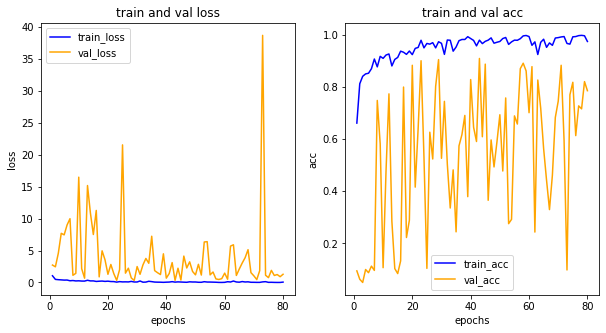

In [15]:
his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 
epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))
# 훈련, 검증 손실
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()
acc = his_dict['acc']
val_acc = his_dict['val_acc']
# 훈련, 검증 정확도
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()
plt.show()